# Setting up all the Imports

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from resizeimage import resizeimage

from vgg16_avg import VGG16_Avg
from bcolz_array_iterator import BcolzArrayIterator
limit_mem()


Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

### Some useful Examples and tips of calling functions with test inputs and experimenting

In [ ]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    ret_val = K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)
    print(ret_val)
    return ret_val

In [ ]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [ ]:
K.eval(mean_sqr_b(K.variable(np.array([[[1.,2],[3,4]],[[1.,2],[3,4]]]))))

In [ ]:
K.eval(K.expand_dims(K.variable(np.array([1,2])),0))

In [ ]:
var=[]
for i in range(6):
    var.append(K.variable(np.array([[[1.,2],[3,4]],[[1.,2],[3,4]]])*i))

In [ ]:
K.eval(content_fn(var))

Cool progress bar for training

## We can run the model quickly with test input and predict

In [ ]:
model = Sequential()
model.add(Deconvolution2D(3, 3, 3, output_shape=(None, 14, 14, 3),
                          border_mode='valid',
                          input_shape=(12, 12, 3)))

dummy_input = np.ones((32,12, 12, 3))
preds = model.predict(dummy_input)
print(preds.shape)

# Opening Images from MS-COCO

In [ ]:
from os import listdir
from os.path import isfile, join
coco_path = '../../../sdey/courses/deeplearning2/data/train2014/'
coco_files = [os.path.join(coco_path, f) for f in listdir(coco_path) if isfile(join(coco_path, f))]

In [ ]:
img = Image.open(coco_files[400])
img

### Code to resize using simd (not parallelism)

In [ ]:
#Change these for different resolutions
lr_s = 72
hr_s = 288
new_s = lr_s
bc_path='res_'+str(new_s)

In [ ]:
tl = threading.local()

In [ ]:
arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), 
                   chunklen=32, mode='w', rootdir=bc_path)

In [ ]:
tl.place = np.zeros((new_s,new_s,3), 'uint8')
#tl.place = np.zeros((new_s,new_s), 'uint8')

In [ ]:
# This is to get the image from the center i.e center crop
def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    tl.place[:] = (np.array(r)[get_slice(r.size[1],new_s), get_slice(r.size[0],new_s)] 
        if r else 0.)
    arr.append(tl.place)

In [ ]:
#Always resizes by the shortest side first. 
def _resize(img, new_s):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

In [ ]:
def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: return
    return _resize(img)

In [ ]:
# Aspect ratio preserving resizing. Convert to numpy array, and append to bcolz carray

for idx, file in enumerate(coco_files):
    img=Image.open(file).convert('RGB')
    app_img(_resize(img, new_s))
    
arr.flush()


### Some sanity checks on input

In [3]:
arr_lr = bcolz.open('res_72')
arr_hr = bcolz.open('res_288')

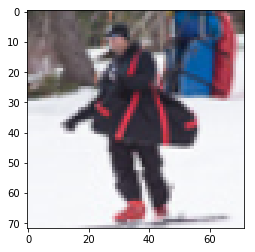

In [4]:
plt.imshow(arr_lr[61420].astype('uint8'))

# Setting up our Neural Network

Some building blocks of our style transfer network. 

In [4]:
def conv_block(x, num_filters, filter_size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(num_filters, filter_size, filter_size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

In [5]:
def res_block(ip, num_filters=64):
    x = conv_block(ip, num_filters, filter_size=3, stride=(1,1))
    x = conv_block(x, num_filters, filter_size=3, stride=(1,1), act=False)
    return merge([x, ip], mode='sum')

In [6]:
def up_block(x, num_filters, filter_size, mode='same'):
    x = keras.layers.UpSampling2D()(x)
    x = conv_block(x, num_filters, filter_size, stride=(1,1), mode=mode)
    return x

In [7]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
vgg_preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [8]:
vgg_deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [9]:
#Use up_block instead of this
# def deconv_block(x, num_filters, filter_size, shape, stride=(2,2)):
#     x = Deconvolution2D(num_filters, filter_size, filter_size, subsample=stride, 
#         border_mode='same', output_shape=(None,) + shape)(x)
#     x = BatchNormalization(mode=2)(x)
#     return Activation('relu')(x)

In [10]:
# Our Super high res CNN that converts a low res image to 4x high res. We will train this.
inp_shape = arr_lr.shape[1:]
inp=Input(inp_shape)
x=BatchNormalization(mode=2)(inp)
x=conv_block(x, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [11]:
# Define feature loss network using VGG. Use this to generate feature maps for the ground truth high res images.
# Make sure to set trainable=False for all layers
# This is the VGG16 bundled in Keras. 
output_shape = arr_hr.shape[1:] #Our Super resolution CNN's output shape. Same as the shape of round truth high res images.
vgg_inp = Input(output_shape)
vgg = VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False

In [12]:
# tap output of three layers. Flatten each, weight each, and finally concat all three together into one tensor.

l_wts = [0.1, 0.8, 0.1] #Weighted sum
layer_names = ['block2_conv2', 'block3_conv2', 'block4_conv2']
assert len(l_wts)==len(layer_names)

def get_weighted_f_map_tensor(layer_name, weight):
    f_map = Flatten()(vgg.get_layer(layer_name).output)
    f_map = Lambda(lambda x: x*weight)(f_map)
    return f_map

In [13]:
f_map_tensors = [get_weighted_f_map_tensor(layer_name, weight) for layer_name, weight in zip(layer_names, l_wts)]

In [14]:
# print sizes for debug/sanity check
tot_size = 0
for layer_name in layer_names:
    l_shape = vgg.get_layer(layer_name).output.shape
    print(l_shape)

(?, 144, 144, 128)
(?, 72, 72, 256)
(?, 36, 36, 512)


In [15]:
# concat all three f_maps 
# output_shape=(None, 2654208 + 1327104 + 663552) = (None, 4644864) 
# , concat_axis=1
#concat_axis=-1 by default. Merges along the feature maps dim. Not batch dim.
def get_merged_f_map_tensors(f_map_tensors):
    if len(f_map_tensors)>1:
        merged_f_maps_tensor = merge(f_map_tensors, mode='concat') 
    elif len(f_map_tensors)==1:
        merged_f_maps_tensor = f_map_tensors[0]
    else:
        raise ValueError("f_map_tensors must be a list of tensors")
    
    return merged_f_maps_tensor

In [16]:
merged_f_maps_tensor = get_merged_f_map_tensors(f_map_tensors)
f_maps_model = Model(input=vgg_inp, output=merged_f_maps_tensor)

#quick sanity check
predicted = f_maps_model.predict(arr_hr[0:2], batch_size=2)
predicted.shape

(2, 4644864)

### Some Bcolz tips: BColzArrayIterator loops inifinitely, no option to stop at the end. When there is a fixed stop, iterate with indexed for loop: Compute ceil of iterations needed to process all data, the last iteration only gives data upto the end of the arary

In [ ]:
# To store feature maps for the entire dataset. WARNING. This takes a lot of storage. For safety 
# the loop breaks on third iteration. If you really know you want to do this, remove if i==2: break.

batch_size=32
its = np.ceil(arr_hr.shape[0]/batch_size)

for i in range(its.astype(int)):
    batch = arr_hr[i*batch_size:(i+1)*batch_size]
    batch_f_maps = f_maps_model.predict_on_batch(batch)
    if i==0:
        sr_target_f_maps = bcolz.carray([batch_f_maps], rootdir='sr_target_f_maps', mode='w')
    else:
        sr_target_f_maps.append([batch_f_maps])
    
    if i==2:
        break

sr_target_f_maps.flush()

In [17]:
# Define final model for super res, tieing all the pieces together
merged_f_maps_tensor = get_merged_f_map_tensors(f_map_tensors)
f_maps_for_originals = Model(input=vgg_inp, output=merged_f_maps_tensor)
f_maps_for_generated = Model(input=vgg_inp, output=merged_f_maps_tensor)(outp)

In [18]:
final_model = Model(inp, output=f_maps_for_generated)

#m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
final_model.compile('adam', 'mse')

In [24]:
# def f_maps_rmse_fn(x):
#     e = x[0]-x[1]
#     esq = e**2
#     rmse = K.sqrt(K.mean(esq, axis=-1))
#     return rmse    

# final_model2 = Model(inp, Lambda(f_maps_rmse_fn)([f_maps_for_generated] + [f_maps_for_originals]))

# final_model2.compile('adam', 'mae')

In [ ]:
def train_final_model(bs=32, npasses=1):
    #targ = np.zeros((bs, 1))
    its_per_pass = np.ceil(arr_hr.shape[0]/bs)
    total_its = npasses * its_per_pass
    bc = BcolzArrayIterator(arr_hr, arr_lr, batch_size=bs)
    targs = K.variable(np.zeros((bs,4644864)))
    for i in range(int(total_its)):
        hr,lr = next(bc)
        targs = f_maps_for_originals.predict_on_batch(hr)
        final_model.train_on_batch(lr, targs)

In [ ]:
train_final_model(npasses=3)

In [ ]:
K.set_value(final_model.optimizer.lr, 1e-4)
train_final_model(npasses=3)

In [27]:
top_model = Model(inp, outp)
top_model.load_weights('my_sr_final.h5')
p = top_model.predict(arr_lr[:20])

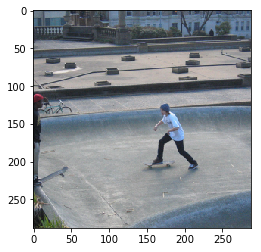

In [40]:
idx=8
plt.imshow(arr_hr[idx].astype('uint8'));

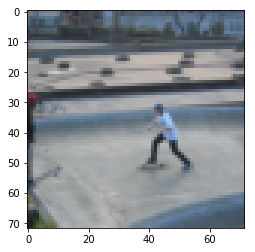

In [41]:
plt.imshow(arr_lr[idx].astype('uint8'));

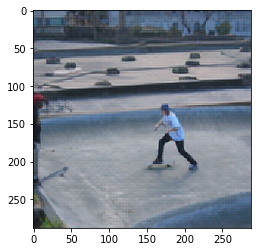

In [43]:
plt.imshow(p[idx].astype('uint8'));

In [ ]:
top_model.save_weights('my_sr_final.h5')

### Predict on an image of different size from the ones the n/w is trained on. (can do this since it is fully convolutional)

In [80]:
test_image = Image.open('data/trials/input/ys.jpg') #data/trials/input/ridhi-arjun-119-small.jpg')

In [81]:
test_image = test_image.resize((512,384))

In [82]:
test_image_arr = np.array(test_image)
test_image_arr = np.expand_dims(test_image_arr, 0)

In [83]:
test_image_arr.shape

(1, 384, 512, 3)

In [84]:
# Change our CNN to accept a different input shape
inp_shape = test_image_arr.shape[1:]
inp=Input(inp_shape)
x=BatchNormalization(mode=2)(inp)
x=conv_block(x, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [85]:
top_model = Model(inp, outp)
top_model.load_weights('my_sr_final.h5')

In [86]:
test_pred = top_model.predict(test_image_arr)

In [87]:
test_pred.shape

(1, 1536, 2048, 3)

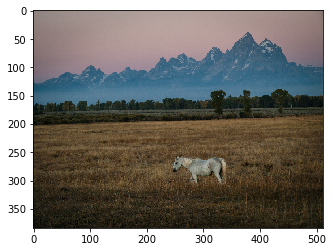

In [88]:
# Low res input
plt.imshow(test_image_arr[0].astype('uint8'));

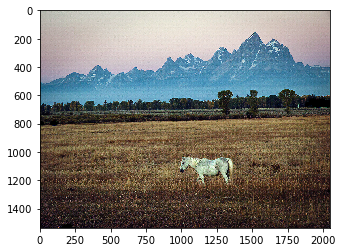

In [89]:
#Generated high resh
plt.imshow(test_pred[0].astype('uint8'));

In [64]:
img = Image.fromarray(test_pred[0], 'RGB')
img.save('my_test_pred.png')
img.show()

In [69]:
img.size

(2048, 1536)